Import library

In [31]:
!pip install mediapipe

In [32]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import shutil
import cv2
import mediapipe as mp
from google.colab.patches import cv2_imshow

In [33]:
import kagglehub

path = kagglehub.dataset_download("mostafaabla/garbage-classification")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/mostafaabla/garbage-classification/versions/1


In [35]:
path = os.path.join(path, 'garbage_classification')


In [ ]:
path

'/root/.cache/kagglehub/datasets/mostafaabla/garbage-classification/versions/1/garbage_classification'

In [ ]:
os.listdir(path)

['shoes',
 'green-glass',
 'plastic',
 'metal',
 'trash',
 'battery',
 'biological',
 'clothes',
 'cardboard',
 'white-glass',
 'brown-glass',
 'paper']

Data collection


In [36]:
root_path = path

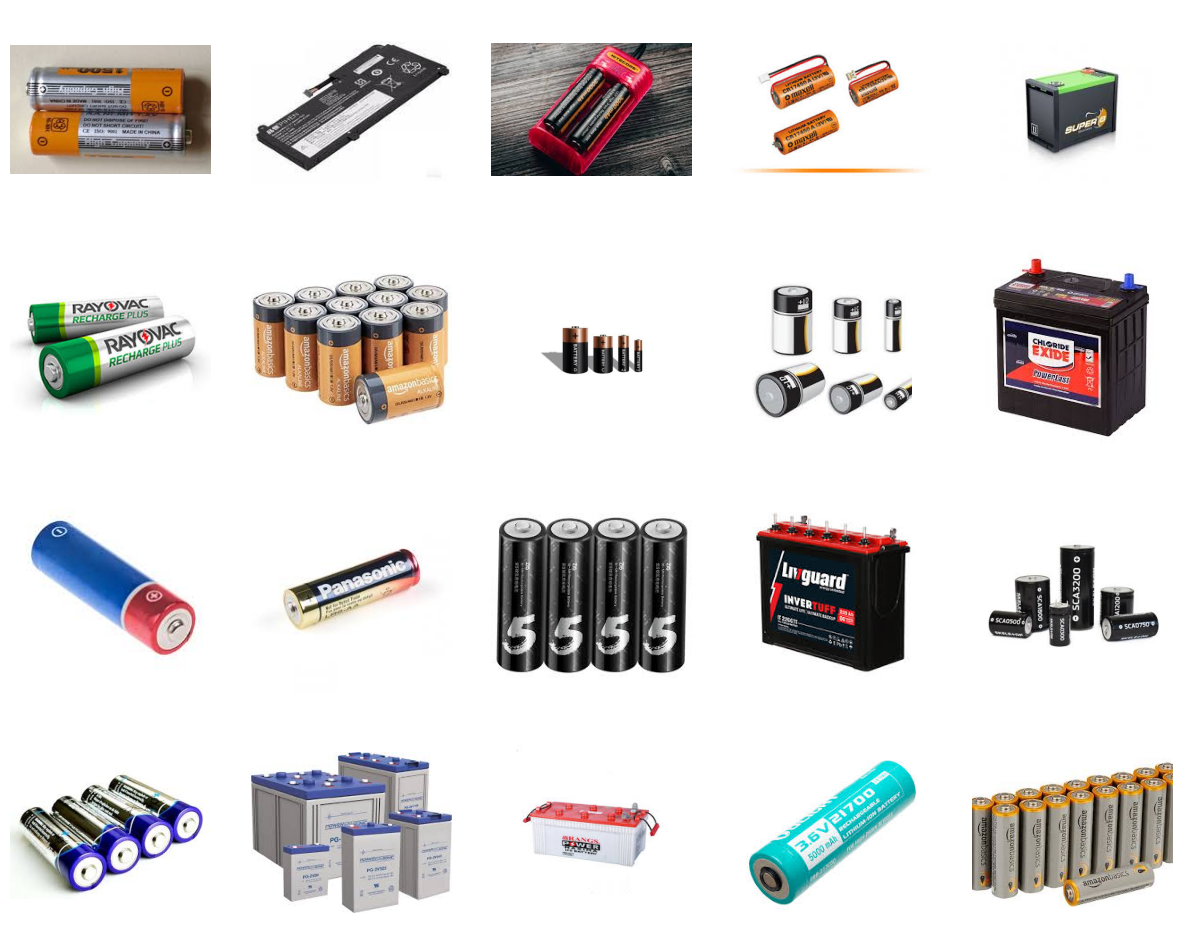

In [37]:
directory_path = os.path.join(path, "battery")
image_files = sorted([file for file in os.listdir(directory_path) if file.lower().endswith(('.jpg', '.jpeg', '.png'))])[:20]
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
for i, image_file in enumerate(image_files):
    img = Image.open(os.path.join(directory_path, image_file))
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    ax.axis('off')
plt.show()

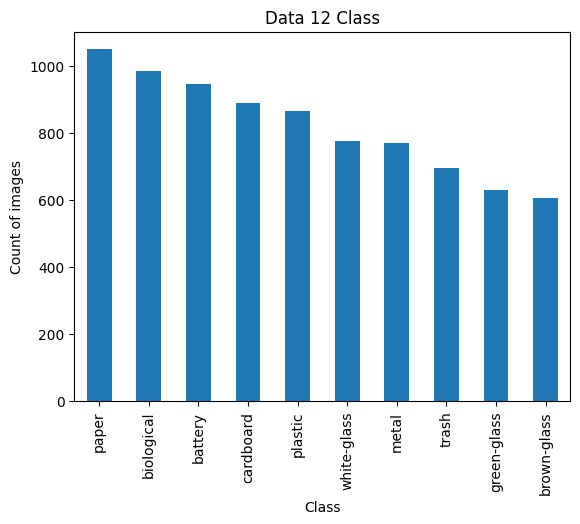

class_
paper          1050
biological      985
battery         945
cardboard       891
plastic         865
white-glass     775
metal           769
trash           697
green-glass     629
brown-glass     607
Name: count, dtype: int64


In [38]:
dir_path = path
data={}
for category in os.listdir(dir_path):
    if category in ['clothes', 'shoes']:
      continue
    category_path = os.path.join(dir_path, category)
    for root, dirs, files in os.walk(category_path):
        for k in files:

            data[os.path.join(dir_path, k)] = category

data=pd.DataFrame(data.items(),columns=['path','class_'])
data['class_'].value_counts().plot(kind='bar')
plt.title('Data 12 Class')
plt.xlabel('Class')
plt.ylabel('Count of images')
plt.show()
print(data['class_'].value_counts())

It is an imbalanced dataset, so we should it make balanced.
For our project we do not need these classes: clothes and shoes

In [39]:
folders_to_remove = ["clothes", "shoes"]
for folder in folders_to_remove:
    folder_path = os.path.join(root_path, folder)
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f"Removed folder: {folder_path}")
    else:
        print(f"Folder not found: {folder_path}")


Folder not found: /root/.cache/kagglehub/datasets/mostafaabla/garbage-classification/versions/1/garbage_classification/clothes
Folder not found: /root/.cache/kagglehub/datasets/mostafaabla/garbage-classification/versions/1/garbage_classification/shoes


# Dataset Creation

In [43]:
!pip install torch torchvision Pillow


In [44]:
import os
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split

In [45]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor(),  # Convert the image to PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize to pretrained model requirements
])

In [46]:
dataset = datasets.ImageFolder(root=root_path, transform=transform)

In [47]:
len(dataset)

8213

In [48]:
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size


train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
val_dataset, test_dataset = random_split(val_dataset, [len(val_dataset)//2, len(val_dataset) - (len(val_dataset)//2)])

In [49]:
train_dataloader =  DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_dataloader =  DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)
test_dataloader =  DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

In [50]:
print(dataset.classes)
print(len(dataset))
print(len(train_dataset)+len(val_dataset)+len(test_dataset))

['battery', 'biological', 'brown-glass', 'cardboard', 'green-glass', 'metal', 'paper', 'plastic', 'trash', 'white-glass']
8213
8213


In [51]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

# Check one sample from the dataloader
data_iter = iter(dataloader)
images, labels = next(data_iter)
print(f"Image batch shape: {images.shape}")
print(f"Labels batch shape: {labels.shape}")
print(labels)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Image batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])
tensor([1, 9, 5, 3, 2, 3, 9, 0, 5, 7, 9, 0, 8, 1, 9, 3, 2, 9, 0, 3, 6, 6, 1, 8,
        7, 7, 1, 2, 1, 0, 9, 6])


# Model training

In [52]:
import pickle
import numpy as np
import torch
from torchvision.models import vgg16, VGG16_Weights
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [53]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [54]:
best_model_wts = None

def train_model(model, criterion, optimizer, num_epoch=10):
    global best_model_wts
    best_accuracy = 0
    losses = []
    accuracies = []

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()

        for inputs, labels in tqdm(train_dataloader, desc=f'Training epoch {epoch}'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

        losses.append(sum(epoch_losses) / len(epoch_losses))
        print(f'Loss: {losses[-1]}')


        epoch_accuracy = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in tqdm(val_dataloader, desc=f'Validation epoch {epoch}'):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                epoch_accuracy += torch.sum(preds == labels).item()

            epoch_accuracy /= len(val_dataset)
            accuracies.append(epoch_accuracy)
            print(f'Validation Accuracy: {epoch_accuracy}')


            if epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_wts = model.state_dict()

    return losses, accuracies



In [ ]:
model = vgg16(weights=VGG16_Weights.DEFAULT).to(device)

# Modify the classifier layer
num_features = model.classifier[6].in_features
num_classes = len(dataset.classes)
model.classifier[6] = nn.Linear(num_features, num_classes).to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

losses, accuracies = train_model(model, criterion, optimizer, num_epoch=100)


Training epoch 0:: 100%|██████████| 231/231 [01:49<00:00,  2.11it/s]


Loss: 2.1785362411887097


Validation epoch 0:: 100%|██████████| 13/13 [00:02<00:00,  4.68it/s]


Validation Accuracy: 0.2773722627737226


Training epoch 1:: 100%|██████████| 231/231 [01:48<00:00,  2.12it/s]


Loss: 1.8594460296424435


Validation epoch 1:: 100%|██████████| 13/13 [00:02<00:00,  5.52it/s]


Validation Accuracy: 0.4257907542579075


Training epoch 2:: 100%|██████████| 231/231 [01:48<00:00,  2.13it/s]


Loss: 1.6508957163079994


Validation epoch 2:: 100%|██████████| 13/13 [00:02<00:00,  5.58it/s]


Validation Accuracy: 0.44525547445255476


Training epoch 3:: 100%|██████████| 231/231 [01:48<00:00,  2.13it/s]


Loss: 1.5287686797963593


Validation epoch 3:: 100%|██████████| 13/13 [00:02<00:00,  5.53it/s]


Validation Accuracy: 0.43795620437956206


Training epoch 4:: 100%|██████████| 231/231 [01:48<00:00,  2.12it/s]


Loss: 1.4108181655148924


Validation epoch 4:: 100%|██████████| 13/13 [00:02<00:00,  5.24it/s]


Validation Accuracy: 0.5060827250608273


Training epoch 5:: 100%|██████████| 231/231 [01:48<00:00,  2.13it/s]


Loss: 1.3624666041626043


Validation epoch 5:: 100%|██████████| 13/13 [00:02<00:00,  5.51it/s]


Validation Accuracy: 0.5742092457420924


Training epoch 6:: 100%|██████████| 231/231 [01:48<00:00,  2.12it/s]


Loss: 1.2661375111831732


Validation epoch 6:: 100%|██████████| 13/13 [00:02<00:00,  5.35it/s]


Validation Accuracy: 0.5717761557177615


Training epoch 7:: 100%|██████████| 231/231 [01:48<00:00,  2.13it/s]


Loss: 1.1560829477908807


Validation epoch 7:: 100%|██████████| 13/13 [00:02<00:00,  5.57it/s]


Validation Accuracy: 0.583941605839416


Training epoch 8:: 100%|██████████| 231/231 [01:48<00:00,  2.13it/s]


Loss: 1.1372299052420116


Validation epoch 8:: 100%|██████████| 13/13 [00:02<00:00,  5.16it/s]


Validation Accuracy: 0.6180048661800487


Training epoch 9:: 100%|██████████| 231/231 [01:47<00:00,  2.14it/s]


Loss: 1.053234259545545


Validation epoch 9:: 100%|██████████| 13/13 [00:02<00:00,  5.49it/s]


Validation Accuracy: 0.6131386861313869


Training epoch 10:: 100%|██████████| 231/231 [01:48<00:00,  2.13it/s]


Loss: 0.9956345124678179


Validation epoch 10:: 100%|██████████| 13/13 [00:02<00:00,  5.32it/s]


Validation Accuracy: 0.6228710462287105


Training epoch 11:: 100%|██████████| 231/231 [01:48<00:00,  2.13it/s]


Loss: 0.9831699429652392


Validation epoch 11:: 100%|██████████| 13/13 [00:02<00:00,  5.52it/s]


Validation Accuracy: 0.6253041362530414


Training epoch 12:: 100%|██████████| 231/231 [01:48<00:00,  2.13it/s]


Loss: 0.9186895923181013


Validation epoch 12:: 100%|██████████| 13/13 [00:02<00:00,  5.28it/s]


Validation Accuracy: 0.6618004866180048


Training epoch 13:: 100%|██████████| 231/231 [01:48<00:00,  2.14it/s]


Loss: 0.9142353712738335


Validation epoch 13:: 100%|██████████| 13/13 [00:02<00:00,  5.50it/s]


Validation Accuracy: 0.6131386861313869


Training epoch 14:: 100%|██████████| 231/231 [01:48<00:00,  2.13it/s]


Loss: 0.9258581899203263


Validation epoch 14:: 100%|██████████| 13/13 [00:02<00:00,  5.47it/s]


Validation Accuracy: 0.6690997566909975


Training epoch 15:: 100%|██████████| 231/231 [01:47<00:00,  2.14it/s]


Loss: 0.831570537059338


Validation epoch 15:: 100%|██████████| 13/13 [00:02<00:00,  5.43it/s]


Validation Accuracy: 0.7128953771289538


Training epoch 16:: 100%|██████████| 231/231 [01:48<00:00,  2.14it/s]


Loss: 0.7788437032080316


Validation epoch 16:: 100%|██████████| 13/13 [00:02<00:00,  5.38it/s]


Validation Accuracy: 0.681265206812652


Training epoch 17:: 100%|██████████| 231/231 [01:47<00:00,  2.14it/s]


Loss: 0.7388235508621513


Validation epoch 17:: 100%|██████████| 13/13 [00:02<00:00,  5.43it/s]


Validation Accuracy: 0.7055961070559611


Training epoch 18:: 100%|██████████| 231/231 [01:47<00:00,  2.15it/s]


Loss: 0.6980821074861469


Validation epoch 18:: 100%|██████████| 13/13 [00:02<00:00,  4.64it/s]


Validation Accuracy: 0.7104622871046229


Training epoch 19:: 100%|██████████| 231/231 [01:48<00:00,  2.14it/s]


Loss: 0.6815745929231891


Validation epoch 19:: 100%|██████████| 13/13 [00:02<00:00,  5.47it/s]


Validation Accuracy: 0.6909975669099757


Training epoch 20:: 100%|██████████| 231/231 [01:47<00:00,  2.14it/s]


Loss: 0.7042653447105771


Validation epoch 20:: 100%|██████████| 13/13 [00:02<00:00,  5.10it/s]


Validation Accuracy: 0.6326034063260341


Training epoch 21:: 100%|██████████| 231/231 [01:47<00:00,  2.14it/s]


Loss: 0.7751382609337439


Validation epoch 21:: 100%|██████████| 13/13 [00:02<00:00,  5.51it/s]


Validation Accuracy: 0.681265206812652


Training epoch 22:: 100%|██████████| 231/231 [01:47<00:00,  2.15it/s]


Loss: 0.5695415864904205


Validation epoch 22:: 100%|██████████| 13/13 [00:02<00:00,  5.56it/s]


Validation Accuracy: 0.7226277372262774


Training epoch 23:: 100%|██████████| 231/231 [01:47<00:00,  2.14it/s]


Loss: 0.600526235030069


Validation epoch 23:: 100%|██████████| 13/13 [00:02<00:00,  4.61it/s]


Validation Accuracy: 0.6253041362530414


Training epoch 24:: 100%|██████████| 231/231 [01:47<00:00,  2.15it/s]


Loss: 0.48684117088328194


Validation epoch 24:: 100%|██████████| 13/13 [00:02<00:00,  5.60it/s]


Validation Accuracy: 0.7201946472019465


Training epoch 25:: 100%|██████████| 231/231 [01:47<00:00,  2.14it/s]


Loss: 0.4541670728749011


Validation epoch 25:: 100%|██████████| 13/13 [00:02<00:00,  4.60it/s]


Validation Accuracy: 0.7299270072992701


Training epoch 26:: 100%|██████████| 231/231 [01:47<00:00,  2.14it/s]


Loss: 0.4239834308043703


Validation epoch 26:: 100%|██████████| 13/13 [00:02<00:00,  5.55it/s]


Validation Accuracy: 0.7007299270072993


Training epoch 27:: 100%|██████████| 231/231 [01:47<00:00,  2.15it/s]


Loss: 0.519492134709895


Validation epoch 27:: 100%|██████████| 13/13 [00:02<00:00,  5.16it/s]


Validation Accuracy: 0.6982968369829684


Training epoch 28:: 100%|██████████| 231/231 [01:47<00:00,  2.14it/s]


Loss: 0.42350427719292705


Validation epoch 28:: 100%|██████████| 13/13 [00:02<00:00,  5.53it/s]


Validation Accuracy: 0.708029197080292


Training epoch 29:: 100%|██████████| 231/231 [01:47<00:00,  2.15it/s]


Loss: 0.37596446588570936


Validation epoch 29:: 100%|██████████| 13/13 [00:02<00:00,  5.52it/s]


Validation Accuracy: 0.7055961070559611


Training epoch 30:: 100%|██████████| 231/231 [01:48<00:00,  2.14it/s]


Loss: 0.40524536184160226


Validation epoch 30:: 100%|██████████| 13/13 [00:02<00:00,  5.48it/s]


Validation Accuracy: 0.6909975669099757


Training epoch 31:: 100%|██████████| 231/231 [01:47<00:00,  2.14it/s]


Loss: 0.7657142020278163


Validation epoch 31:: 100%|██████████| 13/13 [00:02<00:00,  4.53it/s]


Validation Accuracy: 0.6496350364963503


Training epoch 32:: 100%|██████████| 231/231 [01:47<00:00,  2.14it/s]


Loss: 0.5190166096279631


Validation epoch 32:: 100%|██████████| 13/13 [00:02<00:00,  5.54it/s]


Validation Accuracy: 0.6715328467153284


Training epoch 33:: 100%|██████████| 231/231 [01:47<00:00,  2.14it/s]


Loss: 0.4338893023888012


Validation epoch 33:: 100%|██████████| 13/13 [00:02<00:00,  4.63it/s]


Validation Accuracy: 0.6763990267639902


Training epoch 34:: 100%|██████████| 231/231 [01:48<00:00,  2.14it/s]


Loss: 0.386141542458173


Validation epoch 34:: 100%|██████████| 13/13 [00:02<00:00,  5.45it/s]


Validation Accuracy: 0.7055961070559611


Training epoch 35:: 100%|██████████| 231/231 [01:48<00:00,  2.14it/s]


Loss: 0.4569900637387713


Validation epoch 35:: 100%|██████████| 13/13 [00:02<00:00,  5.39it/s]


Validation Accuracy: 0.6715328467153284


Training epoch 36:: 100%|██████████| 231/231 [01:48<00:00,  2.14it/s]


Loss: 0.4188097482184311


Validation epoch 36:: 100%|██████████| 13/13 [00:02<00:00,  5.52it/s]


Validation Accuracy: 0.6593673965936739


Training epoch 37:: 100%|██████████| 231/231 [01:48<00:00,  2.14it/s]


Loss: 0.34703270271743014


Validation epoch 37:: 100%|██████████| 13/13 [00:02<00:00,  5.49it/s]


Validation Accuracy: 0.7153284671532847


Training epoch 38:: 100%|██████████| 231/231 [01:47<00:00,  2.14it/s]


Loss: 0.3511629825320853


Validation epoch 38:: 100%|██████████| 13/13 [00:02<00:00,  4.71it/s]


Validation Accuracy: 0.6885644768856448


Training epoch 39:: 100%|██████████| 231/231 [01:48<00:00,  2.14it/s]


Loss: 0.3285594912834498


Validation epoch 39:: 100%|██████████| 13/13 [00:02<00:00,  5.49it/s]


Validation Accuracy: 0.6934306569343066


Training epoch 40:: 100%|██████████| 231/231 [01:48<00:00,  2.14it/s]


Loss: 0.2454598250343299


Validation epoch 40:: 100%|██████████| 13/13 [00:02<00:00,  4.89it/s]


Validation Accuracy: 0.6934306569343066


Training epoch 41:: 100%|██████████| 231/231 [01:48<00:00,  2.13it/s]


Loss: 0.2874285661458195


Validation epoch 41:: 100%|██████████| 13/13 [00:02<00:00,  5.50it/s]


Validation Accuracy: 0.708029197080292


Training epoch 42:: 100%|██████████| 231/231 [01:48<00:00,  2.13it/s]


Loss: 0.31198255424246646


Validation epoch 42:: 100%|██████████| 13/13 [00:02<00:00,  5.36it/s]


Validation Accuracy: 0.7104622871046229


Training epoch 43:: 100%|██████████| 231/231 [01:48<00:00,  2.14it/s]


Loss: 0.3340915954829036


Validation epoch 43:: 100%|██████████| 13/13 [00:02<00:00,  5.53it/s]


Validation Accuracy: 0.6934306569343066


Training epoch 44:: 100%|██████████| 231/231 [01:48<00:00,  2.14it/s]


Loss: 0.3219810280287679


Validation epoch 44:: 100%|██████████| 13/13 [00:02<00:00,  5.36it/s]


Validation Accuracy: 0.6788321167883211


Training epoch 45:: 100%|██████████| 231/231 [01:47<00:00,  2.14it/s]


Loss: 0.29777099658206946


Validation epoch 45:: 100%|██████████| 13/13 [00:02<00:00,  5.48it/s]


Validation Accuracy: 0.6885644768856448


Training epoch 46:: 100%|██████████| 231/231 [01:48<00:00,  2.13it/s]


Loss: 0.2739553177866327


Validation epoch 46:: 100%|██████████| 13/13 [00:02<00:00,  5.49it/s]


Validation Accuracy: 0.7201946472019465


Training epoch 47:: 100%|██████████| 231/231 [01:47<00:00,  2.14it/s]


Loss: 0.30424360211664464


Validation epoch 47:: 100%|██████████| 13/13 [00:02<00:00,  5.44it/s]


Validation Accuracy: 0.6763990267639902


Training epoch 48:: 100%|██████████| 231/231 [01:48<00:00,  2.14it/s]


Loss: 0.29186014427896184


Validation epoch 48:: 100%|██████████| 13/13 [00:02<00:00,  5.49it/s]


Validation Accuracy: 0.7226277372262774


Training epoch 49:: 100%|██████████| 231/231 [01:48<00:00,  2.14it/s]


Loss: 0.20862077693434763


Validation epoch 49:: 100%|██████████| 13/13 [00:02<00:00,  5.27it/s]


Validation Accuracy: 0.7055961070559611


Training epoch 50:: 100%|██████████| 231/231 [01:47<00:00,  2.14it/s]


Loss: 0.24276060319920897


Validation epoch 50:: 100%|██████████| 13/13 [00:02<00:00,  5.53it/s]


Validation Accuracy: 0.6739659367396593


Training epoch 51:: 100%|██████████| 231/231 [01:48<00:00,  2.14it/s]


Loss: 0.26126837490924765


Validation epoch 51:: 100%|██████████| 13/13 [00:02<00:00,  5.37it/s]


Validation Accuracy: 0.708029197080292


Training epoch 52:: 100%|██████████| 231/231 [01:47<00:00,  2.14it/s]


Loss: 0.23356578773637485


Validation epoch 52:: 100%|██████████| 13/13 [00:02<00:00,  5.46it/s]


Validation Accuracy: 0.6861313868613139


Training epoch 53:: 100%|██████████| 231/231 [01:48<00:00,  2.14it/s]


Loss: 0.20624615745094818


Validation epoch 53:: 100%|██████████| 13/13 [00:02<00:00,  5.51it/s]


Validation Accuracy: 0.6861313868613139


Training epoch 54:: 100%|██████████| 231/231 [01:47<00:00,  2.14it/s]


Loss: 0.1792242688235718


Validation epoch 54:: 100%|██████████| 13/13 [00:02<00:00,  5.23it/s]


Validation Accuracy: 0.6934306569343066


Training epoch 55:: 100%|██████████| 231/231 [01:48<00:00,  2.14it/s]


Loss: 0.15545322749465382


Validation epoch 55:: 100%|██████████| 13/13 [00:02<00:00,  5.51it/s]


Validation Accuracy: 0.7031630170316302


Training epoch 56:: 100%|██████████| 231/231 [01:47<00:00,  2.14it/s]


Loss: 0.2228383193542431


Validation epoch 56:: 100%|██████████| 13/13 [00:02<00:00,  5.05it/s]


Validation Accuracy: 0.6739659367396593


Training epoch 57:: 100%|██████████| 231/231 [01:48<00:00,  2.14it/s]


Loss: 0.2976747108200057


Validation epoch 57:: 100%|██████████| 13/13 [00:02<00:00,  5.48it/s]


Validation Accuracy: 0.7031630170316302


Training epoch 58:: 100%|██████████| 231/231 [01:48<00:00,  2.14it/s]


Loss: 0.21225001234803106


Validation epoch 58:: 100%|██████████| 13/13 [00:02<00:00,  4.59it/s]


Validation Accuracy: 0.7104622871046229


Training epoch 59:: 100%|██████████| 231/231 [01:48<00:00,  2.14it/s]


Loss: 0.34062568882069033


Validation epoch 59:: 100%|██████████| 13/13 [00:02<00:00,  5.47it/s]


Validation Accuracy: 0.7055961070559611


Training epoch 60:: 100%|██████████| 231/231 [01:48<00:00,  2.14it/s]


Loss: 0.29657472723296713


Validation epoch 60:: 100%|██████████| 13/13 [00:02<00:00,  4.84it/s]


Validation Accuracy: 0.7007299270072993


Training epoch 61:: 100%|██████████| 231/231 [01:47<00:00,  2.14it/s]


Loss: 0.1974508731577594


Validation epoch 61:: 100%|██████████| 13/13 [00:02<00:00,  5.45it/s]


Validation Accuracy: 0.6958637469586375


Training epoch 62:: 100%|██████████| 231/231 [01:47<00:00,  2.14it/s]


Loss: 0.18394068528361845


Validation epoch 62:: 100%|██████████| 13/13 [00:02<00:00,  5.57it/s]


Validation Accuracy: 0.6885644768856448


Training epoch 63:: 100%|██████████| 231/231 [01:47<00:00,  2.14it/s]


Loss: 0.18680362858773245


Validation epoch 63:: 100%|██████████| 13/13 [00:02<00:00,  5.05it/s]


Validation Accuracy: 0.6958637469586375


Training epoch 64:: 100%|██████████| 231/231 [01:48<00:00,  2.14it/s]


Loss: 0.24248928203574055


Validation epoch 64:: 100%|██████████| 13/13 [00:02<00:00,  5.52it/s]


Validation Accuracy: 0.683698296836983


Training epoch 65::  72%|███████▏  | 166/231 [01:17<00:30,  2.17it/s]